In [1]:
import random
import torch
import utils
import data_utils
import similarity
import cv2 as cv
import time
import numpy as np
from openai import OpenAI
import base64
from PIL import Image
import io
import pandas as pd

In [5]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'layer3'
d_probe = 'broden'
concept_set = 'data/10k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi


save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity_fn, device=device)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)
vals, idsx = torch.topk(similarities,k=1,largest=True)

image_sets = [[pil_data[j][0].resize([128,128]) for j in i] for i in np.array(top_ids).T]

clip_label = [words[int(i)] for i in idsx]

100%|██████████| 1024/1024 [00:03<00:00, 312.51it/s]


torch.Size([1024, 9894])


In [4]:
def combine_images_grid(images):
    # Assuming 'images' is a list containing four PIL image objects
    
    # Get the dimensions of each image
    width, height = images[0].size

    # Calculate the size of the new image grid
    new_width = width * 2
    new_height = height * 2

    # Create a new image with the calculated size
    new_image = Image.new('RGB', (new_width, new_height))

    # Paste each image onto the new canvas
    for i in range(2):
        for j in range(2):
            index = i * 2 + j
            if index < len(images):
                new_image.paste(images[index], (j * width, i * height))

    return new_image

def process_pil_image(image):
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")
    
    image_base64 = base64.b64encode(buffered.getvalue()).decode()
    return f'data:image/jpeg;base64,{image_base64}'

This is a stitch of 4 different image, describe each one and how they may relate.

 The collage consists of four pictures featuring various birds perched on branches or leaves in their natural habitat. In the first picture, there are two birds sitting together on a branch amidst flowers. The second picture depicts another bird standing alone among some plants. The third image shows a group of nine birds resting on grass near a tree while one bird is eating. Finally, the fourth picture displays a lone bird sitting in the branches of a tree with multiple leaves around it. These photographs showcase different stages of daily life for these birds in their natural environment.

Explain how this stitch of 4 images might relate to the concept of 'bird feeder
'
 The four photographs capture a bird perched on tree branches with other birds in the background. This stitch of images could be related to a bird feeder, as it shows various types of birds interacting and feeding together at the same l

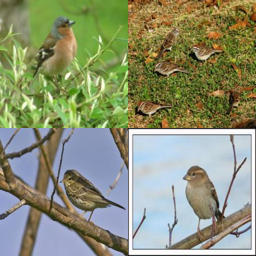

In [122]:
i = 10
print("This is a stitch of 4 different image, describe each one and how they may relate.\n")
print(df["describe"][i])
print()
print(f"Explain how this stitch of 4 images might relate to the concept of '{clip_label[i]}\n'")
print(df["relation"][i])
combine_images_grid(image_sets[i])

In [43]:
stitched = combine_images_grid()

In [84]:
for i in range(1,20):
    describe = prompt_model(image_sets[i], "This is a stitch of 4 different image, describe each one and how they may relate.")
    relation = prompt_model(image_sets[i], f"Explain how this stitch of 4 images might relate to the concept of '{clip_label[i]}'")
    df = pd.concat([df, pd.DataFrame({"describe":[describe],"relation":[relation]})])
    df.to_csv('LLaVAtest/'+"_".join([clip_name,target_name,target_layer,d_probe,concept_set]).replace('.','').replace('/','') + '.csv')                       
    

In [7]:
client = OpenAI(base_url="http://localhost:8000/v1", api_key="sk-1234")

def prompt_model(image,text):
    response = client.chat.completions.create(
        model="llava-local",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": process_pil_image(image),
                        },
                    },
                    {"type": "text", "text": text},
                ],
            }
        ],
    )

    return response.choices[0].message.content

## Yes or No

In [9]:
df = pd.DataFrame([])

In [ ]:
for i in range(len(image_sets)):
    for j,image in enumerate(image_sets[i]):
        for k in range(3):
            yes_or_no = prompt_model(image,f"Does this image relate to the concept of '{clip_label[i]}', answer in one word Yes or No")
            df = pd.concat([df, pd.DataFrame({"neuron_idx":[i],"image_idx":[j],"k_run":[k],"answer":[yes_or_no]})])
            df.to_csv('LLaVAtest/'+"_".join([clip_name,target_name,target_layer,d_probe,concept_set]).replace('.','').replace('/','') +"_yesno"+ '.csv')                       





In [18]:
df = pd.read_csv("LLaVAtest/ViT-B16_resnet50_fc_broden_databroden_labels_cleantxt_yesno.csv")
df = df.drop(columns=["Unnamed: 0"])
df["bool"] = df["answer"].apply(lambda x: 1 if x == " Yes" else 0)

In [30]:
# average by single image
grouped_df = pd.DataFrame(df.groupby(['neuron_idx','image_idx'])["bool"].mean())
#df


# average by activating images
pd.DataFrame(grouped_df.reset_index().groupby('neuron_idx')["bool"].mean()).rename(columns={"bool":"confidence"})


,confidence
neuron_idx,
1,0.800000
2,0.850000
3,0.850000
4,1.000000
5,0.900000
6,0.450000
7,0.600000
8,0.550000
9,0.950000


In [64]:
combine_images_grid(image_sets[5])
clip_label[5]


'dotted'